This notebook is meant to be run in the [data-science jupyter notebook stack](https://github.com/jupyter/docker-stacks/tree/master/datascience-notebook). The main dependencies are scikit-learn, numpy and matplotlib, as well as `time` to benchmark different algorithms.

In [1]:
%matplotlib inline
import time
import sklearn.cluster as cl
import sklearn.metrics as mt
import sklearn.utils as ut
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Simple simulations: mixture of Gaussians
## Simulate time series
Let's start with a function which simulates time series. The simulation uses the following parameters:

In [2]:
n_time = 100     # number of time samples
n_roi = 150      # number of regions
n_clusters = np.array([5])   # number  of clusters 
alpha = 0.3     # this parameter controls the "strength" of the clustering.

The following function deals with the simulation of the time series, and uses a mixture model of Gaussians. The function also supports multiresolution clusters, but we will get at that latter. For now we start with a small number of regions (300), a small number of regions (300) and 5 clusters of equal size. The `alpha` parameter is set quite low (SNR of about 0.1), so that there is a challenge.

In [3]:
def simu_tseries(n_time,n_roi,n_clusters,alpha) :
    y = np.random.normal(size=[n_roi , n_time])
    gt = np.zeros(shape=[n_roi,n_clusters.size])
    
    for ss in range(0,n_clusters.size) :
        ind = np.linspace(0,n_roi,n_clusters[ss]+1,dtype="int")
        for cc in range(0, n_clusters[ss]) :
            cluster = range(ind[cc],ind[cc+1])
            sig = np.random.normal(size=[1,n_time])
            y[cluster,:] = y[cluster,:] + alpha * np.repeat(sig,ind[cc+1]-ind[cc],0)
            gt[cluster,ss] = cc
    return y , gt

Let's simulate the time series, and visualize the correspoding matrix of time correlation coefficients across regions.

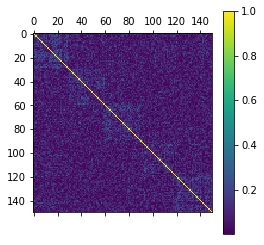

In [4]:
y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
R = sp.corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()

The `simu_tseries` function also create a vector of integer labels, which defines the true cluster structure.

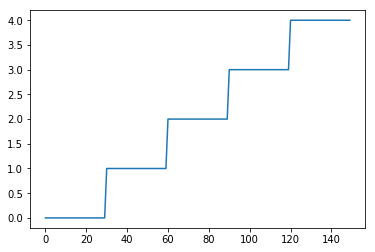

In [5]:
plt.plot(gt)

## Spectral cluster bagging
EAC is much slower than k-means, but it also uses much more memory. That's because it builds a p x p matrices, where p is the number of points to classify, while k-means uses a p x k array, where k is the desired number of clusters. The idea of the spectral cluster bagging is to represent partitions using indicator vectors, and replace the averaging by a special value decomposition.

In [8]:
def scb(y , n_clusters , n_batch = 3 , n_samp = 10 ) :
    dimv = n_clusters
    vecb = np.zeros([y.shape[0],dimv,n_batch])
    for bb in range(0,n_batch) :
        vec = np.zeros([y.shape[0],dimv,n_samp])
        for ss in range(0,n_samp) :
            cent , part , inert  = cl.k_means(y,n_clusters=n_clusters,init="random",max_iter=30)
            for cc in range(0,n_clusters) :
                vec[:,cc,ss] = part == cc
        vec = vec.astype(int)
        vec = vec.reshape([y.shape[0],dimv*n_samp])
        u, s, vh = np.linalg.svd(vec, full_matrices=False)
        vecb[:,:,bb] = u[:,0:dimv]
    vecb = vecb.reshape([y.shape[0],dimv*n_batch])
    u, s, vh = np.linalg.svd(vecb, full_matrices=False)
    u = u[:,0:dimv]
    beta = np.matmul(u.transpose(),y)
    yh = np.matmul(u,beta)
    cent , cons , inert  = cl.k_means(yh,n_clusters=n_clusters,init="random",max_iter=30)
    return cons, yh, u

3.6309419999999992 seconds process time


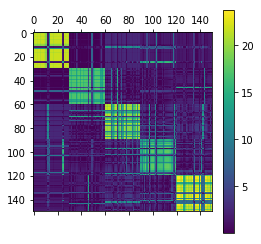

In [9]:
t0 = time.clock()
cons, yh, u = scb(y , n_clusters=5 , n_batch=3 , n_samp=10)
print(time.clock()-t0, "seconds process time")
R = np.matmul(yh,yh.transpose())
plt.matshow(np.abs(R))
plt.colorbar()

/home/pbellec/env/jupyter_ml/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Model performance (adjusted rand):  0.7303582834733606


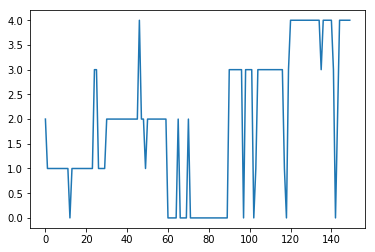

In [10]:
plt.plot(cons)
perf = mt.normalized_mutual_info_score(cons,gt[:,0])
print("Model performance (adjusted rand): " , perf)

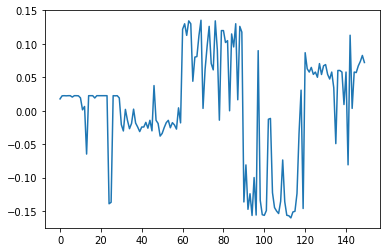

In [15]:
plt.plot(u[:,4])

Let's evaluate the performance of the spectral cluster aggregation

So k-means++ is faster, and gets even more accurate than SCA. But we can SCA based on k-means++ ...

In [ ]:
def scapp(y , n_clusters , n_batch = 3 , n_samp = 10 ) :
    dimv = n_clusters
    vecb = np.zeros([y.shape[0],dimv,n_batch])
    for bb in range(0,n_batch) :
        vec = np.zeros([y.shape[0],dimv,n_samp])
        for ss in range(0,n_samp) :
            cent , part , inert  = cl.k_means(y,n_clusters=n_clusters,init="k-means++",max_iter=30)
            for cc in range(0,n_clusters) :
                vec[:,cc,ss] = part == cc
        vec = vec.astype(int)
        vec = vec.reshape([y.shape[0],dimv*n_samp])
        u, s, vh = np.linalg.svd(vec, full_matrices=False)
        vecb[:,:,bb] = u[:,0:dimv]
    vecb = vecb.reshape([y.shape[0],dimv*n_batch])
    u, s, vh = np.linalg.svd(vecb, full_matrices=False)
    u = u[:,0:dimv]
    beta = np.matmul(u.transpose(),y)
    yh = np.matmul(u,beta)
    cent , cons , inert  = cl.k_means(yh,n_clusters=n_clusters,init="k-means++",max_iter=30)
    return cons, yh
                